In [13]:
#Importing sys so we can importy Optics.py
import sys
sys.path.insert(0, '~/Initial-Allignment-Assistant-Tool')
#Importing all the definitions form Optics.py
from Optics import *

import Parameters

#Imports numpy
import numpy as np
#Imports improtant functions for juptyer display
from IPython.core.display import display, HTML, Markdown, clear_output
#Improts matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
#Improts widgets for buttons and text boxes for jupyter display
import ipywidgets as widgets
#Imports parser for ini files
import configparser
#Import os to see files and directories
import os
#Colormaps
import matplotlib.cm as cm
#For legends of imshow
import matplotlib.patches as mpatches
#To save pictures as jpg
import PIL

from Parameters import *

def rotateMatrix(mat): 
        N = len(mat)
        for x in range(0, int(N/2)):
            for y in range(x, N-x-1): 
                temp = mat[x][y]
                mat[x][y] = mat[y][N-1-x]
                mat[y][N-1-x] = mat[N-1-x][N-1-y]
                mat[N-1-x][N-1-y] = mat[N-1-y][x]
                mat[N-1-y][x] = temp 

def calculatePlotParameters(beam0, elements0, elementView, elementControl, extraYaws, extraPitches):
    #Makes a copy of the beam
    beam = beam0.copy()
    beamDefault = beam0.copy()
    #Makes a copy of all the elements
    elements = [element.copy() for element in elements0]
    elementsDefault = [element.copy() for element in elements0]

    #Shifts the pitch and yaw of all the elements accordingly
    for i in range(len(elements)):
        elements[i].pitch = elements[i].pitch + extraPitches[i]
        elements[i].yaw = elements[i].yaw + extraYaws[i]
    #Finds the ID os the element that is being controlled (not useful yet, but no harm in it).
    for iCtrl in range(len(elements)):
        if elements[iCtrl].ID == elementControl:
            break
    #Finds the ID os the element that is being viewed.
    for iView in range(len(elements)):
        if elements[iView].ID == elementView:
            break
            
    #Calculates the states of the beam at each element.
    states = beam.calculateStates(elements)
    statesDefault = beam.calculateStates(elementsDefault)
    #Calculates the flags for non-intersection and clipping
    flags = beam.calculateFlags(elements)
    
    #Returns the dictionary with all necessary information for the plot.
    return {
            "Title": "View: " + str(elementView) + " | Control: " + str(elementControl),
            "Range": np.array([-1, 1])*elements[iView].diameter*1.1/2.0,
            "BeamCenter": rotatePitchYaw(states[elementView].position - elements[iView].positionOfCM, -elements[iView].pitch, -elements[iView].yaw)[1:],
            "BeamRadius": states[elementView].width,
            "BeamCenterDefault": rotatePitchYaw(statesDefault[elementView].position - elementsDefault[iView].positionOfCM, -elementsDefault[iView].pitch, -elementsDefault[iView].yaw)[1:],
            "BeamRadiusDefault": statesDefault[elementView].width,
            "Flags": flags            
           }

def colorPointDiscrete(x,y, radLines = 10, angLines = 10, lineThickness = .01, alphaFactor = 1):
    r = np.sqrt(x**2 + y**2)
    ph = np.arctan2(y,x)%(2*np.pi)
    
    if r > 1:
        return (0,0,0,1)
    
    phs = np.linspace(0, 2*np.pi, num = angLines + 1)
    i = 0
    while ph >= phs[i]:
        i += 1        
        
    rs = np.linspace(0, 1, num = radLines + 1)
    
    j = 0
    while r >= rs[j]:
        j += 1
    
    if angLines != 0:
        for r in [1/angLines*n for n in range(angLines)]:
            if abs(np.sqrt(x**2 + y**2) - r) <= lineThickness:
                return np.array((0,0,0,1))
    
    if radLines != 0:
        for th in [2*np.pi/radLines*n for n in range(radLines)]:
            d = np.array([x,y]) - np.sqrt(x**2 + y**2)*np.array([np.cos(th),np.sin(th)])
            if np.sqrt(d[0]**2 + d[1]**2) <= lineThickness:
                return np.array((0,0,0,1))
    color = np.array(cm.hsv(phs[i]/(2*np.pi),np.exp(-2*rs[j])))
    color[-1] = color[-1]*alphaFactor
    return color

def colorPointContinuous(x,y, radLines = 10, angLines = 10, lineThickness = .01, alphaFactor = 1):
    r = np.sqrt(x**2 + y**2)
    ph = np.arctan2(y,x)%(2*np.pi)
    
    if r > 1:
        return (0,0,0,1)
    
    if angLines != 0:
        for rho in [1/angLines*n for n in range(angLines)]:
            if abs(r - rho) <= lineThickness:
                return np.array((0,0,0,1))
    
    if radLines != 0:
        for th in [2*np.pi/radLines*n for n in range(radLines)]:
            d = np.array([x,y]) - r*np.array([np.cos(th),np.sin(th)])
            if np.sqrt(d[0]**2 + d[1]**2) <= lineThickness:
                return np.array((0,0,0,1))

    color = np.array(cm.hsv(ph/(2*np.pi),np.exp(-2*r)))
    color[-1] = color[-1]*alphaFactor
    return color

def findRanges(system, movableElements):
    beam = Parameters.beamFromFile('Systems/' + system)
    elements = Parameters.elementsFromFile('Systems/' + system)
    
    moveIDs = []
    
    elementsMove = []
    for i in range(len(elements)):
        if elements[i].ID in movableElements:
            moveIDs += [i]
            
    ranges = []
    
    for i in moveIDs:
        #Test elements to find proper ranges.
        elemsTemp = []
        for element in elements:
            elemsTemp += [element.copy()]
        guessRangeYaw = [0, 0]
        guessRangePitch = [0, 0]
        maxIterations = 500
        findingMinYaw = True
        findingMaxYaw = True
        findingMinPitch = True
        findingMaxPitch = True
        j = 0
        
        while((findingMinYaw and findingMaxYaw and findingMinPitch and findingMaxPitch) and j <= maxIterations):
            beamTemp = beam.copy()
            elemsTemp[i].yaw = elemsTemp[i].yaw + guessRangeYaw[0]
            flagsMinYaw = beamTemp.calculateFlags(elemsTemp)
            elemsTemp[i].yaw = elemsTemp[i].yaw - guessRangeYaw[0]
            elemsTemp[i].yaw = elemsTemp[i].yaw + guessRangeYaw[1]
            flagsMaxYaw = beamTemp.calculateFlags(elemsTemp)
            elemsTemp[i].yaw = elemsTemp[i].yaw - guessRangeYaw[1]

            elemsTemp[i].pitch = elemsTemp[i].pitch + guessRangePitch[0]
            flagsMinPitch = beamTemp.calculateFlags(elemsTemp)
            elemsTemp[i].pitch = elemsTemp[i].pitch - guessRangePitch[0]
            elemsTemp[i].pitch = elemsTemp[i].pitch + guessRangePitch[1]
            flagsMaxPitch = beamTemp.calculateFlags(elemsTemp)
            elemsTemp[i].pitch = elemsTemp[i].pitch - guessRangePitch[1]

            if len(flagsMinYaw) > 0 and 'not intersecting' in flagsMinYaw[-1] and elements[-1].ID in flagsMinYaw[-1]:
                findingMinYaw = False
            else:
                guessRangeYaw[0] = guessRangeYaw[0] - 1e-5
            

            if len(flagsMaxYaw) > 0 and 'not intersecting' in flagsMaxYaw[-1] and elements[-1].ID in flagsMaxYaw[-1]:
                findingMaxYaw = False
            else:
                guessRangeYaw[1] = guessRangeYaw[1] + 1e-5
                
            if len(flagsMinPitch) > 0 and 'not intersecting' in flagsMinPitch[-1] and elements[-1].ID in flagsMinPitch[-1]:
                findingMinPitch = False
            else:
                guessRangePitch[0] = guessRangePitch[0] - 1e-5
        
            if len(flagsMaxPitch) > 0 and 'not intersecting' in flagsMaxPitch[-1] and elements[-1].ID in flagsMaxPitch[-1]:
                findingMaxPitch = False
            else:
                guessRangePitch[1] = guessRangePitch[1] + 1e-5
            
            j += 1

        ranges += [[[guessRangeYaw[0]*1.2,guessRangeYaw[1]*1.2], [guessRangePitch[0]*1.2,guessRangePitch[1]*1.2]]]
    return ranges

1 / 3
2 / 3
3 / 3


/home/andre.guimaraes/.conda/envs/IAAT-Env/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


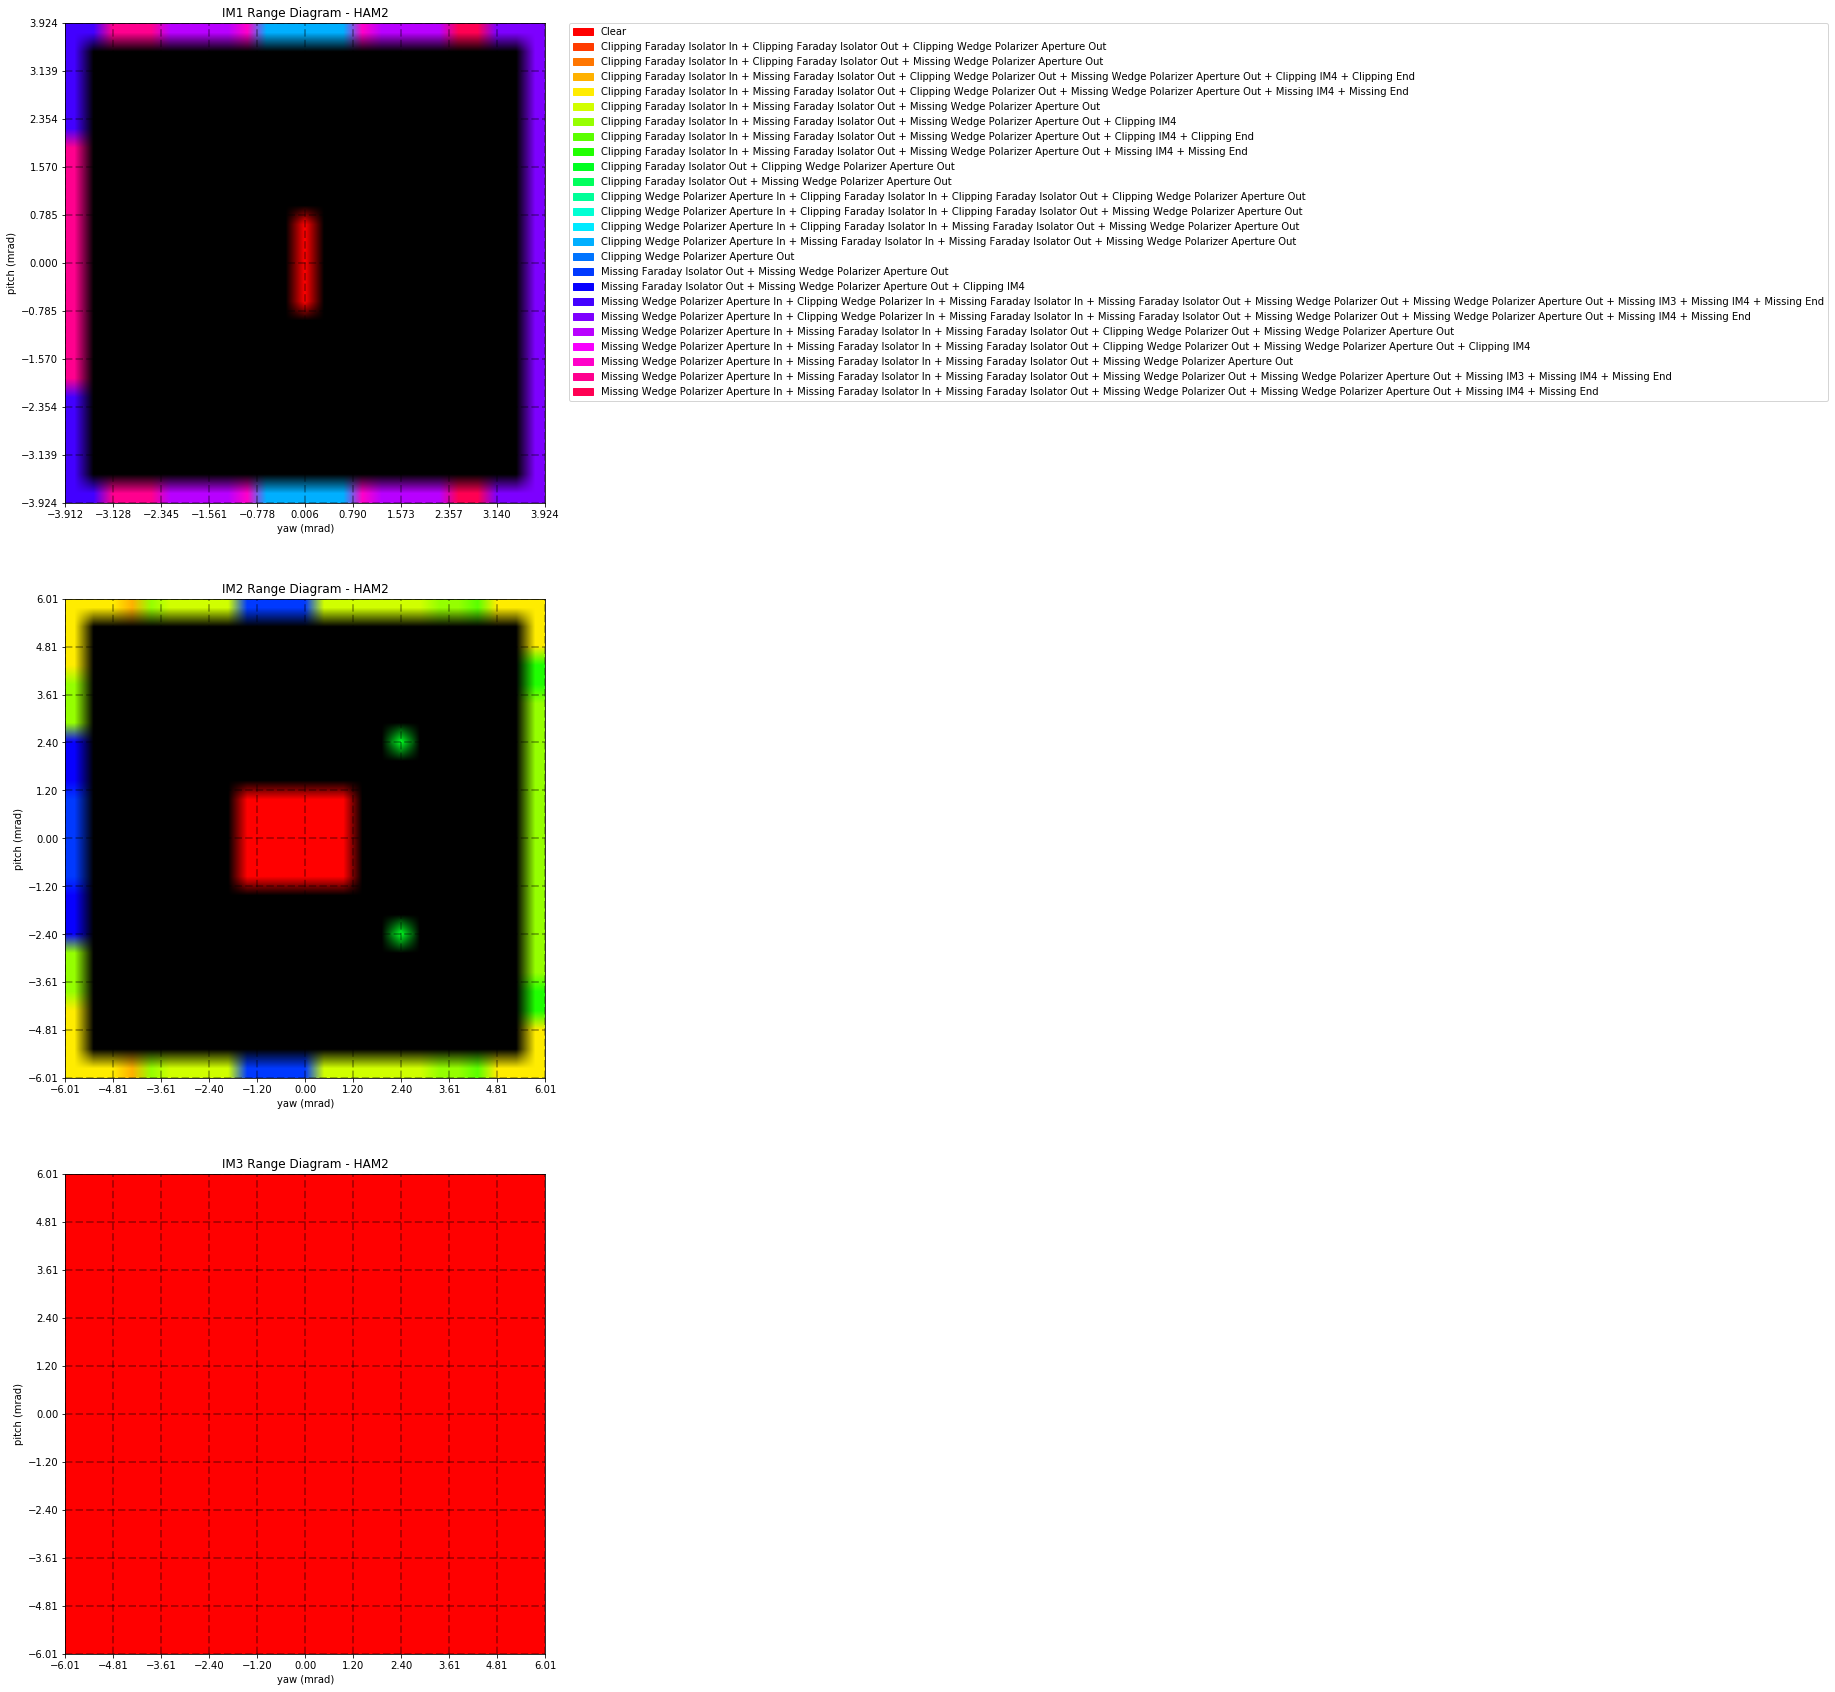

In [40]:
system = 'HAM2 - Default.ini'

beam = Parameters.beamFromFile('Systems/' + system)

elements = Parameters.elementsFromFile('Systems/' + system)

MovableElements = ['IM1', 'IM2', 'IM3']

detail = 25
#HAM2
#ranges = [[[-0.015,0.015],[-0.015,0.015]],[[-0.015,0.015],[-0.015,0.015]],[[-0.015,0.015],[-0.015,0.015]],[[-0.015,0.015],[-0.015,0.015]]]
ranges = findRanges(system = system, movableElements = MovableElements)

#------------------------------------------------------------------------------------------------#

moveID = []
for i in range(len(elements)):
    if elements[i].ID in MovableElements:
        moveID += [i]

ptsElem = []


for i in moveID:
    pts = []
    elemsTemp = [element.copy() for element in elements]
    ran = ranges[MovableElements.index(elements[i].ID)]
    for yaw in np.linspace(ran[0][0], ran[0][1], num = detail):
        for pitch in np.linspace(ran[1][0], ran[1][1], num = detail):
            elemsTemp[i] = elements[i].copy()
            elemsTemp[i].yaw =  elements[i].yaw + yaw
            elemsTemp[i].pitch =  elements[i].pitch + pitch
            flags = beam.calculateFlags(elemsTemp)
            if len(flags) == 0:
                pts += [[yaw, pitch, 'Clear']]
            else:
                label = ""
                for j in range(len(elemsTemp)):
                    for flag in flags:
                        if elemsTemp[j].ID in flag:
                            if 'clipping' in flag:
                                if label != "":
                                    label += ' + '
                                label += 'Clipping ' + elemsTemp[j].ID
                            else:
                                if label != "":
                                    label += ' + '
                                label += 'Missing ' + elemsTemp[j].ID
                pts += [[yaw, pitch, label]]
    ptsElem += [pts]

possibleFlags = []
for pts in ptsElem:
    for pt in pts:
        possibleFlags += [pt[2]]
possibleFlags = np.unique(possibleFlags)
possibleColors = [cm.hsv(n/len(possibleFlags)) for n in range(len(possibleFlags))]

fig, ax = plt.subplots(len(MovableElements), 1, figsize = [10,30])
markBoundaries = True
#Reccomend: detail/200
lineWidthPixels = 2

for j in range(len(ptsElem)):
    print(str(j+1) + " / " + str(len(ptsElem)))
    i = 0
    colors = [[]]
    for yaw in np.linspace(ran[0][0],ran[0][1],num = detail):
        for pitch in np.linspace(ran[1][0],ran[1][1],num = detail):
            arg = np.argwhere(possibleFlags == [ptsElem[j][i][2]])[0][0]        
            colors[-1] += [possibleColors[arg]]
            i += 1
        colors += [[]]

    colors = colors[:-1]

    rotateMatrix(colors)
    if markBoundaries:
        for repeat in range(lineWidthPixels):
            colorsTemp = np.array(colors)
            for k in range(1,len(colors)-1):
                for l in range(1,len(colors[k])-1):
                    if sum(colors[k][l]) != sum(colors[k+1][l]) or sum(colors[k][l]) != sum(colors[k-1][l]) or sum(colors[k][l]) != sum(colors[k][l+1]) or sum(colors[k][l]) != sum(colors[k][l-1]):
                        colorsTemp[k][l] = [0,0,0,1]
            colors = colorsTemp.tolist()
    
    patches = [mpatches.Patch(color=possibleColors[i], label = possibleFlags[i]) for i in range(len(possibleColors))]
    
    ax[j].imshow(colors, interpolation = 'bilinear', extent = 1e3*np.ravel(np.array(ranges[j])))
    ax[j].set_xlabel('yaw (mrad)')
    ax[j].set_ylabel('pitch (mrad)')
    ax[j].set_title(MovableElements[j] + ' Range Diagram - ' + system.split()[0])
    #ax[j].set_aspect(1)
    ax[j].set_aspect((ranges[j][0][1]-ranges[j][0][0])/(ranges[j][1][1]-ranges[j][1][0]))
    ax[j].set_xticks(np.linspace(1e3*ranges[j][0][0],1e3*ranges[j][0][1],num = 11))
    ax[j].set_yticks(np.linspace(1e3*ranges[j][1][0],1e3*ranges[j][1][1],num = 11))
    ax[j].grid(color = 'black', linestyle = '--', linewidth = 2, alpha = .3)
    if j == 0:
        lgd = ax[j].legend(handles = patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.tight_layout()

In [34]:
len(moveID)

24

In [142]:
system = 'HAM2 - Default.ini'

beam = Parameters.beamFromFile('Systems/' + system)

elements = Parameters.elementsFromFile('Systems/' + system)

MovableElements = ['IM1', 'IM2', 'IM3', 'IM4']
#MovableElements = ['IM1']

detail = 10

#PRC
#ranges = [[[-5e-3,5e-3],[-5e-3,5e-3]], [[-5e-3,5e-3],[-5e-3,5e-3]], [[-1,2.3],[-1.5,1.5]]]
#ranges = findRanges(system, MovableElements)

#Example01
#ranges = [[[-.3,.3],[-.3,.3]], [[-.1,.1],[-.1,.1]], [[-np.pi/2,np.pi/2],[-np.pi/2,np.pi/2]]]

#HAM2
ranges = [[[-0.015,0.015],[-0.015,0.015]],[[-0.015,0.015],[-0.015,0.015]],[[-0.015,0.015],[-0.015,0.015]],[[-0.015,0.015],[-0.015,0.015]]]

ptsElem = []

for analyzeElementIndex in range(len(elements)):
    
    if elements[analyzeElementIndex].ID in MovableElements:

        pts = []

        elemsTemp = []

        for element in elements:
            elemsTemp += [element.copy()]
        ran = ranges[analyzeElementIndex]
        for yaw in np.linspace(ran[0][0],ran[0][1],num = detail):
            for pitch in np.linspace(ran[1][0],ran[1][1],num = detail):
                elemsTemp[analyzeElementIndex] = elements[analyzeElementIndex].copy()
                elemsTemp[analyzeElementIndex].yaw =  elements[analyzeElementIndex].yaw + yaw
                elemsTemp[analyzeElementIndex].pitch =  elements[analyzeElementIndex].pitch + pitch

                flags = beam.calculateFlags(elemsTemp)

                if len(flags) == 0:
                    pts += [[yaw, pitch, 'Clear']]
                else:
                    label = ""
                    for i in range(len(elemsTemp)):
                        for flag in flags:
                            if elemsTemp[i].ID in flag:
                                if 'clipping' in flag:
                                    if label != "":
                                        label += ' + '
                                    label += 'Clipping ' + elemsTemp[i].ID
                                else:
                                    if label != "":
                                        label += ' + '
                                    label += 'Missing ' + elemsTemp[i].ID
                    pts += [[yaw, pitch, label]]

        ptsElem += [pts]

possibleFlags = []

for pts in ptsElem:
    for pt in pts:
        possibleFlags += [pt[2]]
    
possibleFlags = np.unique(possibleFlags)

possibleColors = [cm.hsv(n/len(possibleFlags)) for n in range(len(possibleFlags))]

fig, ax = plt.subplots(len(ptsElem),1,figsize = [10,30])

markBoundaries = True

#Reccomend: detail/200
lineWidthPixels = 2

for j in range(len(ptsElem)):
    i = 0
    colors = [[]]
    for yaw in np.linspace(ran[0][0],ran[0][1],num = detail):
        for pitch in np.linspace(ran[1][0],ran[1][1],num = detail):
            arg = np.argwhere(possibleFlags == [ptsElem[j][i][2]])[0][0]        
            colors[-1] += [possibleColors[arg]]
            i += 1
        colors += [[]]

    colors = colors[:-1]

    rotateMatrix(colors)
    if markBoundaries:
        for repeat in range(lineWidthPixels):
            colorsTemp = np.array(colors)
            for k in range(1,len(colors)-1):
                for l in range(1,len(colors[k])-1):
                    if sum(colors[k][l]) != sum(colors[k+1][l]) or sum(colors[k][l]) != sum(colors[k-1][l]) or sum(colors[k][l]) != sum(colors[k][l+1]) or sum(colors[k][l]) != sum(colors[k][l-1]):
                        colorsTemp[k][l] = [0,0,0,1]
            colors = colorsTemp.tolist()
    
    patches = [mpatches.Patch(color=possibleColors[i], label = possibleFlags[i]) for i in range(len(possibleColors))]
    
    ax[j].imshow(colors, interpolation = 'bilinear', extent = 1e3*np.ravel(np.array(ranges[j])))
    ax[j].set_xlabel('yaw (mrad)')
    ax[j].set_ylabel('pitch (mrad)')
    ax[j].set_title(elements[j].ID + ' Range Diagram - ' + system.split()[0])
    #ax[j].set_aspect(1)
    ax[j].set_aspect((ranges[j][0][1]-ranges[j][0][0])/(ranges[j][1][1]-ranges[j][1][0]))
    ax[j].set_xticks(np.linspace(1e3*ranges[j][0][0],1e3*ranges[j][0][1],num = 11))
    ax[j].set_yticks(np.linspace(1e3*ranges[j][1][0],1e3*ranges[j][1][1],num = 11))
    ax[j].grid(color = 'black', linestyle = '--', linewidth = 2, alpha = .3)
    lgd = ax[j].legend(handles = patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.tight_layout()
#fig.savefig(system.split()[0] + ' Range Diagrams.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')

IndexError: list index out of range

In [ ]:
system = 'HAM2 - Default.ini'

beam = Parameters.beamFromFile('Systems/' + system)

elements = Parameters.elementsFromFile('Systems/' + system)

detail = 1000

#PRC
#ranges = [[[-5e-3,5e-3],[-5e-3,5e-3]], [[-5e-3,5e-3],[-5e-3,5e-3]], [[-1,2.3],[-1.5,1.5]]]

#Example01
#ranges = [[[-.3,.3],[-.3,.3]], [[-.1,.1],[-.1,.1]], [[-np.pi/2,np.pi/2],[-np.pi/2,np.pi/2]]]

#HAM2
ranges = [[[-8e-3,8e-3],[-8e-3,8e-3]], [[-6e-3,6e-3],[-6e-3,6e-3,]], [[-6e-3,6e-3],[-6e-3,6e-3]],[[-1,1],[-1,1]]]

ptsElem = []

for analyzeElementIndex in range(len(elements)):

    pts = []
    
    elemsTemp = []

    for element in elements:
        elemsTemp += [element.copy()]
    ran = ranges[analyzeElementIndex]
    for yaw in np.linspace(ran[0][0],ran[0][1],num = detail):
        for pitch in np.linspace(ran[1][0],ran[1][1],num = detail):
            elemsTemp[analyzeElementIndex] = elements[analyzeElementIndex].copy()
            elemsTemp[analyzeElementIndex].yaw =  elements[analyzeElementIndex].yaw + yaw
            elemsTemp[analyzeElementIndex].pitch =  elements[analyzeElementIndex].pitch + pitch

            flags = beam.calculateFlags(elemsTemp)
            
            if len(flags) == 0:
                pts += [[yaw, pitch, 'Clear']]
            else:
                label = ""
                for i in range(len(elemsTemp)):
                    for flag in flags:
                        if elemsTemp[i].ID in flag:
                            if 'clipping' in flag:
                                if label != "":
                                    label += ' + '
                                label += 'Clipping ' + elemsTemp[i].ID
                            else:
                                if label != "":
                                    label += ' + '
                                label += 'Missing ' + elemsTemp[i].ID
                pts += [[yaw, pitch, label]]
    ptsElem += [pts]

possibleFlags = []

for pts in ptsElem:
    for pt in pts:
        possibleFlags += [pt[2]]
    
possibleFlags = np.unique(possibleFlags)

possibleColors = [cm.hsv(n/len(possibleFlags)) for n in range(len(possibleFlags))]

fig, ax = plt.subplots(len(ptsElem),1,figsize = [10,30])

markBoundaries = True

#Reccomend: detail/200
lineWidthPixels = 2

for j in range(len(ptsElem)):
    i = 0
    colors = [[]]
    for yaw in np.linspace(ran[0][0],ran[0][1],num = detail):
        for pitch in np.linspace(ran[1][0],ran[1][1],num = detail):
            arg = np.argwhere(possibleFlags == [ptsElem[j][i][2]])[0][0]        
            colors[-1] += [possibleColors[arg]]
            i += 1
        colors += [[]]

    colors = colors[:-1]

    rotateMatrix(colors)
    if markBoundaries:
        for repeat in range(lineWidthPixels):
            colorsTemp = np.array(colors)
            for k in range(1,len(colors)-1):
                for l in range(1,len(colors[k])-1):
                    if sum(colors[k][l]) != sum(colors[k+1][l]) or sum(colors[k][l]) != sum(colors[k-1][l]) or sum(colors[k][l]) != sum(colors[k][l+1]) or sum(colors[k][l]) != sum(colors[k][l-1]):
                        colorsTemp[k][l] = [0,0,0,1]
            colors = colorsTemp.tolist()
    
    patches = [mpatches.Patch(color=possibleColors[i], label = possibleFlags[i]) for i in range(len(possibleColors))]
    
    ax[j].imshow(colors, interpolation = 'bilinear', extent = 1e3*np.ravel(np.array(ranges[j])))
    ax[j].set_xlabel('yaw (mrad)')
    ax[j].set_ylabel('pitch (mrad)')
    ax[j].set_title(elements[j].ID + ' Range Diagram - ' + system.split()[0])
    ax[j].set_aspect(1)
    ax[j].set_xticks(np.linspace(1e3*ranges[j][0][0],1e3*ranges[j][0][1],num = 11))
    ax[j].set_yticks(np.linspace(1e3*ranges[j][1][0],1e3*ranges[j][1][1],num = 11))
    ax[j].grid(color = 'black', linestyle = '--', linewidth = 2, alpha = .3)
    lgd = ax[j].legend(handles = patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.savefig(system.split()[0] + ' Range Diagrams.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')

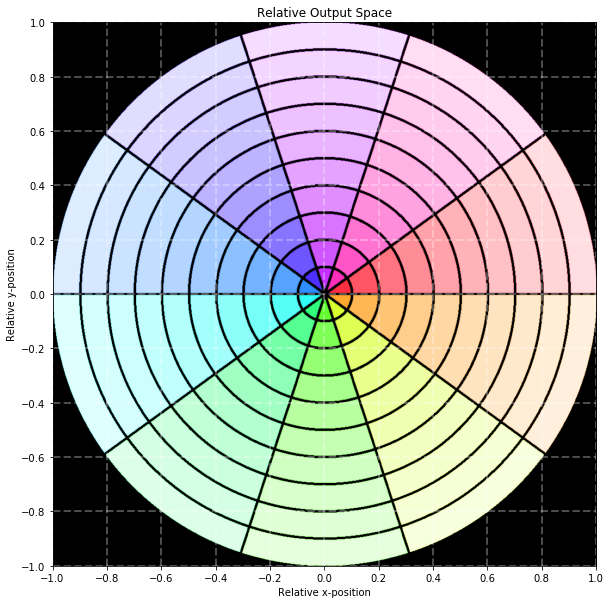

In [3]:
#Output Space discrete
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
            
detail = 1000

fig, ax = plt.subplots(figsize = [10,10])

colors = [[]]

for y in np.linspace(-1,1,num = detail):
    for x in np.linspace(-1,1,num = detail):
        if x**2 + y**2 > 1:
            colors[-1] += [[0,0,0,1]]
        else:
            colors[-1] += [colorPointDiscrete(x, y, radLines = 10, angLines = 10, lineThickness = .005)]
    colors += [[]]
    
colors = colors[:-1]

ax.imshow(colors, interpolation = 'bilinear', extent = [-1,1,-1,1])
ax.set_xlabel('Relative x-position')
ax.set_ylabel('Relative y-position')
ax.set_title('Relative Output Space')
ax.set_aspect(1)
ax.set_xticks(np.linspace(-1, 1, num = 11))
ax.set_yticks(np.linspace(-1, 1, num = 11))
ax.grid(color = 'white', linestyle = '--', linewidth = 2, alpha = .3)

fig.savefig('Discrete Output Space.jpg')

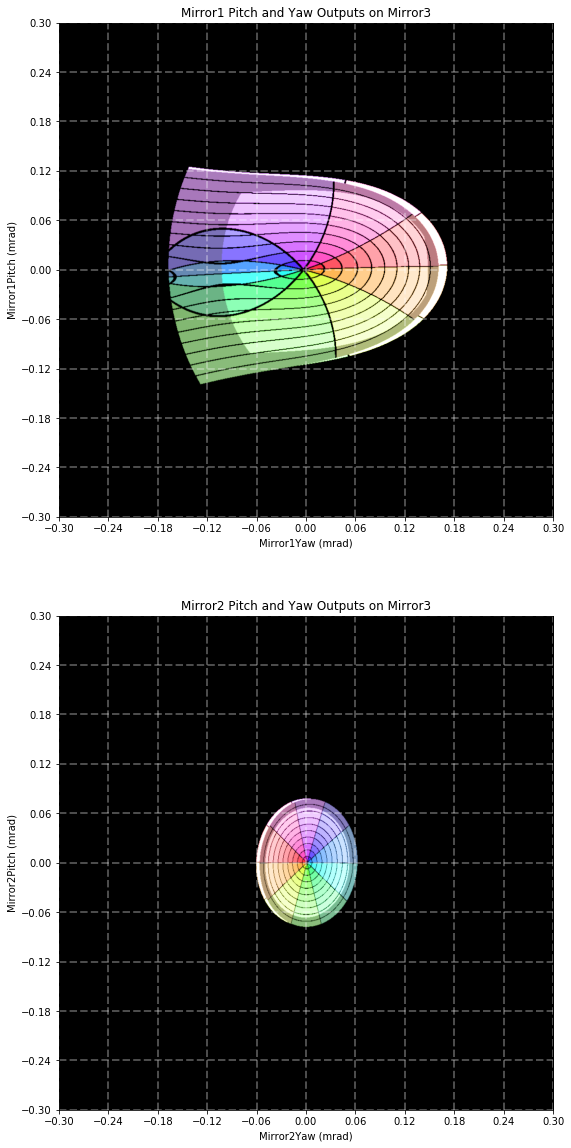

In [28]:
#Output Space Projection Map Discrete

system = 'Example01 - Default.ini'

beam = Parameters.beamFromFile('Systems/' + system)

elements = Parameters.elementsFromFile('Systems/' + system)

detail = 1000

fig, ax = plt.subplots(len(elements)-1, 1, figsize = [10,20])

r = .3

for analyzeElementIndex in range(len(elements)-1):
    pts = []
    colors = [[]]
    elemsTemp = [element.copy() for element in elements]
    for pitch in np.linspace(-r, r, num = detail):
        for yaw in np.linspace(-r, r, num = detail):
            elemsTemp[analyzeElementIndex] = elements[analyzeElementIndex].copy()
            elemsTemp[analyzeElementIndex].yaw =  elements[analyzeElementIndex].yaw + yaw
            elemsTemp[analyzeElementIndex].pitch =  elements[analyzeElementIndex].pitch + pitch

            flags = beam.calculateFlags(elemsTemp)
            f = ''
            for flag in flags:
                f += flag
            yaws = [0 for element in elemsTemp]
            pitches = [0 for element in elemsTemp]
            
            yaws[analyzeElementIndex] = yaw
            pitches[analyzeElementIndex] = pitch

            params = calculatePlotParameters(beam, elements, [element.ID for element in elemsTemp][-1], [element.ID for element in elemsTemp][analyzeElementIndex], yaws, pitches)

            x = params['BeamCenter'][0]/(elements[-1].diameter/2)
            y = params['BeamCenter'][1]/(elements[-1].diameter/2)

            if len(f) > 0:
                if 'clipping' in f and 'intersecting' not in f:
                    colors[-1] += (0.5*np.array([colorPointDiscrete(x, y, radLines = 10, angLines = 10, lineThickness = .005, alphaFactor = .3)]) + 0.5*np.array([0,0,0,1])).tolist()
                else:  
                    colors[-1] += [colorPointDiscrete(x, y, radLines = 10, angLines = 10, lineThickness = .005, alphaFactor = 0)]
            else:
                colors[-1] += [colorPointDiscrete(x, y, radLines = 10, angLines = 10, lineThickness = .005, alphaFactor = 1)]
        colors += [[]]

    colors = colors[:-1]

#    ax[analyzeElementIndex].imshow(colors, interpolation = 'bilinear', extent = [-r*1e3,r*1e3,-r*1e3,r*1e3])
    ax[analyzeElementIndex].imshow(colors, interpolation = 'bilinear', extent = [-r,r,-r,r])
    ax[analyzeElementIndex].set_title(elements[analyzeElementIndex].ID + ' Pitch and Yaw Outputs on ' + elements[-1].ID)
    ax[analyzeElementIndex].set_xlabel(elements[analyzeElementIndex].ID + 'Yaw (mrad)')
    ax[analyzeElementIndex].set_ylabel(elements[analyzeElementIndex].ID + 'Pitch (mrad)')
    ax[analyzeElementIndex].set_aspect(1)
#    ax[analyzeElementIndex].set_xticks(np.linspace(-r*1e3, r*1e3, num = 11))
    ax[analyzeElementIndex].set_xticks(np.linspace(-r, r, num = 11))
#    ax[analyzeElementIndex].set_yticks(np.linspace(-r*1e3, r*1e3, num = 11))
    ax[analyzeElementIndex].set_yticks(np.linspace(-r, r, num = 11))
    ax[analyzeElementIndex].grid(color = 'white', linestyle = '--', linewidth = 2, alpha = .3)
fig.savefig('Discrete ' + system.split()[0] + ' Projection Map.jpg')

In [ ]:
#Output Space continuous

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
            
detail = 1000

fig, ax = plt.subplots(figsize = [10,10])

colors = [[]]

for y in np.linspace(-1,1,num = detail):
    for x in np.linspace(-1,1,num = detail):
        if x**2 + y**2 > 1:
            colors[-1] += [[0,0,0,1]]
        else:
            colors[-1] += [colorPointContinuous(x, y, radLines = 10, angLines = 10, lineThickness = .005)]
    colors += [[]]
    
colors = colors[:-1]

ax.imshow(colors, interpolation = 'bilinear', extent = [-1,1,-1,1])
ax.set_xlabel('Relative x-position')
ax.set_ylabel('Relative y-position')
ax.set_title('Relative Output Space')
ax.set_aspect(1)
ax.set_xticks(np.linspace(-1, 1, num = 11))
ax.set_yticks(np.linspace(-1, 1, num = 11))
ax.grid(color = 'white', linestyle = '--', linewidth = 2, alpha = .3)
fig.savefig('Continuous Output Space.jpg')

In [ ]:
#Output Space Projection Map Continuous

system = 'PRC - Default.ini'

beam = Parameters.beamFromFile('Systems/' + system)

elements = Parameters.elementsFromFile('Systems/' + system)

detail = 1000

fig, ax = plt.subplots(len(elements)-1, 1, figsize = [10,20])

r = 5e-3

for analyzeElementIndex in range(len(elements)-1):
    pts = []
    colors = [[]]
    elemsTemp = [element.copy() for element in elements]
    for pitch in np.linspace(-r, r, num = detail):
        for yaw in np.linspace(-r, r, num = detail):
            elemsTemp[analyzeElementIndex] = elements[analyzeElementIndex].copy()
            elemsTemp[analyzeElementIndex].yaw =  elements[analyzeElementIndex].yaw + yaw
            elemsTemp[analyzeElementIndex].pitch =  elements[analyzeElementIndex].pitch + pitch

            flags = beam.calculateFlags(elemsTemp)
            f = ''
            for flag in flags:
                f += flag
            yaws = [0 for element in elemsTemp]
            pitches = [0 for element in elemsTemp]
            
            yaws[analyzeElementIndex] = yaw
            pitches[analyzeElementIndex] = pitch

            params = calculatePlotParameters(beam, elements, [element.ID for element in elemsTemp][-1], [element.ID for element in elemsTemp][analyzeElementIndex], yaws, pitches)

            x = params['BeamCenter'][0]/(elements[-1].diameter/2)
            y = params['BeamCenter'][1]/(elements[-1].diameter/2)

            if len(f) > 0:
                if 'clipping' in f and 'intersecting' not in f:
                    colors[-1] += (0.5*np.array([colorPointContinuous(x, y, radLines = 10, angLines = 10, lineThickness = .005, alphaFactor = .3)]) + 0.5*np.array([0,0,0,1])).tolist()
                else:  
                    colors[-1] += [colorPointContinuous(x, y, radLines = 10, angLines = 10, lineThickness = .005, alphaFactor = 0)]
            else:
                colors[-1] += [colorPointContinuous(x, y, radLines = 10, angLines = 10, lineThickness = .005, alphaFactor = 1)]
        colors += [[]]

    colors = colors[:-1]

    ax[analyzeElementIndex].imshow(colors, interpolation = 'bilinear', extent = [-r*1e3,r*1e3,-r*1e3,r*1e3])
    ax[analyzeElementIndex].set_title('PR2 Pitch and Yaw Outputs on BS')
    ax[analyzeElementIndex].set_xlabel('PR2 Yaw (mrad)')
    ax[analyzeElementIndex].set_ylabel('PR2 Pitch (mrad)')
    ax[analyzeElementIndex].set_aspect(1)
    ax[analyzeElementIndex].set_xticks(np.linspace(-r*1e3, r*1e3, num = 11))
    ax[analyzeElementIndex].set_yticks(np.linspace(-r*1e3, r*1e3, num = 11))
    ax[analyzeElementIndex].grid(color = 'white', linestyle = '--', linewidth = 2, alpha = .3)
fig.savefig('Continuos ' + system.split()[0] + ' Projection Map.jpg')

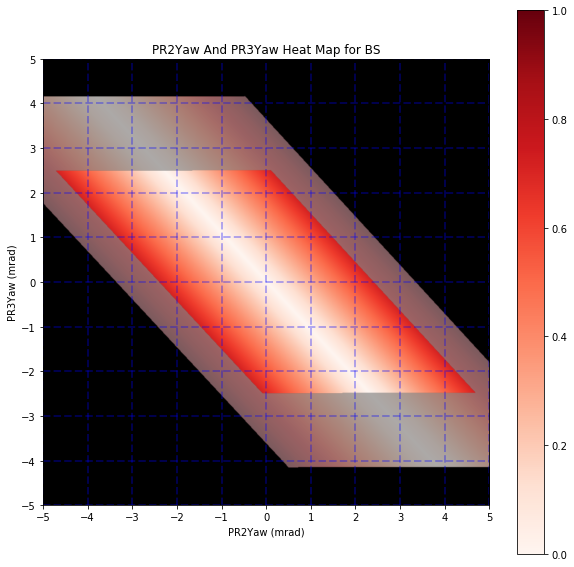

In [10]:
#Heat map plot thing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors  

system = 'PRC - Default.ini'

beam = Parameters.beamFromFile('Systems/' + system)

elements = Parameters.elementsFromFile('Systems/' + system)

detail = 1000

pts = []
    
elemsTemp = []

for element in elements:
    elemsTemp += [element.copy()]

fig, ax = plt.subplots(figsize = [10,10])

colors = [[]]

r = 5e-3

for yaw1 in np.linspace(-r, r, num = detail):
    for yaw2 in np.linspace(-r, r, num = detail):
        elemsTemp[0] = elements[0].copy()
        elemsTemp[1] = elements[1].copy()
        
        elemsTemp[0].yaw =  elements[0].yaw + yaw1
        elemsTemp[1].yaw =  elements[1].yaw + yaw2

        flags = beam.calculateFlags(elemsTemp)
        f = ''
        for flag in flags:
            f += flag
        yaws = [0 for element in elemsTemp]
        pitches = [0 for element in elemsTemp]
        yaws[0] = yaw1
        yaws[1] = yaw2
                        
        params = calculatePlotParameters(beam, elements, [element.ID for element in elemsTemp][-1], [element.ID for element in elemsTemp][-1], yaws, pitches)

        x = params['BeamCenter'][0]/(elements[-1].diameter/2)
        y = params['BeamCenter'][1]/(elements[-1].diameter/2)

        if len(f) > 0:
            if 'clipping' in f and 'intersecting' not in f:
                colors[-1] += [(0.5*np.array(cm.Reds(np.sqrt(x**2+y**2),.3)) + 0.5*np.array([0,0,0,1])).tolist()]
            else:
                colors[-1] += [[0,0,0,1]]
        else:
            colors[-1] += [cm.Reds(np.sqrt(x**2+y**2))]
    colors += [[]] 

colors = colors[:-1]

ax.imshow(colors, interpolation = 'bilinear', extent = [-r*1e3, r*1e3, -r*1e3, r*1e3])
ax.set_title('PR2Yaw And PR3Yaw Heat Map for BS')
ax.set_xlabel('PR2Yaw (mrad)')
ax.set_ylabel('PR3Yaw (mrad)')
ax.set_aspect(1)
ax.set_xticks(np.linspace(-r*1e3, r*1e3, num = 11))
ax.set_yticks(np.linspace(-r*1e3, r*1e3, num = 11))
ax.grid(color = 'blue', linestyle = '--', linewidth = 2, alpha = .3)
fig.colorbar(cm.ScalarMappable(cmap = cm.Reds), ax=ax)
fig.savefig('PR2 Yaw and PR3 Yaw Heat Map for BS.jpg')

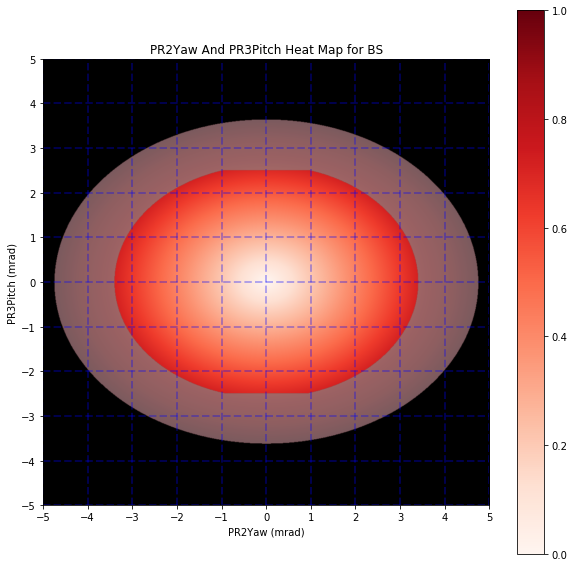

In [11]:
#Heat map plot thing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors  

system = 'PRC - Default.ini'

beam = Parameters.beamFromFile('Systems/' + system)

elements = Parameters.elementsFromFile('Systems/' + system)

detail = 1000

pts = []
    
elemsTemp = []

for element in elements:
    elemsTemp += [element.copy()]

fig, ax = plt.subplots(figsize = [10,10])

colors = [[]]

r = 5e-3

for yaw1 in np.linspace(-r, r, num = detail):
    for pitch2 in np.linspace(-r, r, num = detail):
        elemsTemp[0] = elements[0].copy()
        elemsTemp[1] = elements[1].copy()
        
        elemsTemp[0].yaw =  elements[0].yaw + yaw1
        elemsTemp[1].pitch =  elements[1].pitch + pitch2

        flags = beam.calculateFlags(elemsTemp)
        f = ''
        for flag in flags:
            f += flag
        yaws = [0 for element in elemsTemp]
        pitches = [0 for element in elemsTemp]
        yaws[0] = yaw1
        pitches[1] = pitch2
                        
        params = calculatePlotParameters(beam, elements, [element.ID for element in elemsTemp][-1], [element.ID for element in elemsTemp][-1], yaws, pitches)

        x = params['BeamCenter'][0]/(elements[-1].diameter/2)
        y = params['BeamCenter'][1]/(elements[-1].diameter/2)

        if len(f) > 0:
            if 'clipping' in f and 'intersecting' not in f:
                colors[-1] += [(0.5*np.array(cm.Reds(np.sqrt(x**2+y**2),.3)) + 0.5*np.array([0,0,0,1])).tolist()]
            else:
                colors[-1] += [[0,0,0,1]]
        else:
            colors[-1] += [cm.Reds(np.sqrt(x**2+y**2))]
    colors += [[]] 

colors = colors[:-1]

ax.imshow(colors, interpolation = 'bilinear', extent = [-r*1e3, r*1e3, -r*1e3, r*1e3])
ax.set_title('PR2Yaw And PR3Pitch Heat Map for BS')
ax.set_xlabel('PR2Yaw (mrad)')
ax.set_ylabel('PR3Pitch (mrad)')
ax.set_aspect(1)
ax.set_xticks(np.linspace(-r*1e3, r*1e3, num = 11))
ax.set_yticks(np.linspace(-r*1e3, r*1e3, num = 11))
ax.grid(color = 'blue', linestyle = '--', linewidth = 2, alpha = .3)
fig.colorbar(cm.ScalarMappable(cmap = cm.Reds), ax=ax)
fig.savefig('PR2 Yaw and PR3 Pitch Heat Map for BS.jpg')

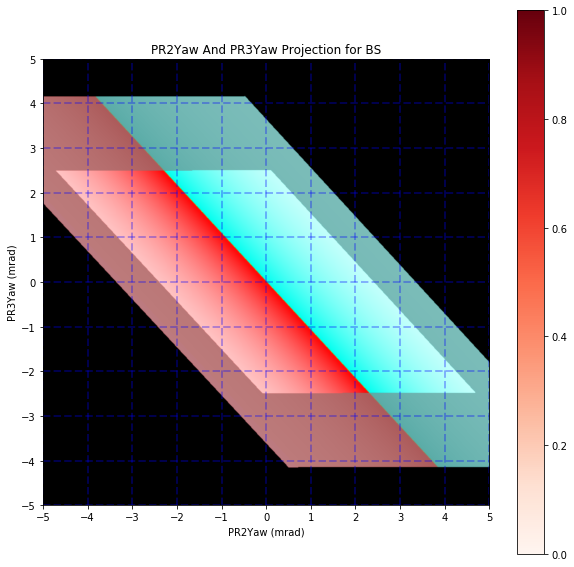

In [12]:
#Heat map plot thing + Continuous porjection
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors  

system = 'PRC - Default.ini'

beam = Parameters.beamFromFile('Systems/' + system)

elements = Parameters.elementsFromFile('Systems/' + system)

detail = 1000

pts = []
    
elemsTemp = []

for element in elements:
    elemsTemp += [element.copy()]

fig, ax = plt.subplots(figsize = [10,10])

colors = [[]]

r = 5e-3

for yaw1 in np.linspace(-r, r, num = detail):
    for yaw2 in np.linspace(-r, r, num = detail):
        elemsTemp[0] = elements[0].copy()
        elemsTemp[1] = elements[1].copy()
        
        elemsTemp[0].yaw =  elements[0].yaw + yaw1
        elemsTemp[1].yaw =  elements[1].yaw + yaw2

        flags = beam.calculateFlags(elemsTemp)
        f = ''
        for flag in flags:
            f += flag
        yaws = [0 for element in elemsTemp]
        pitches = [0 for element in elemsTemp]
        yaws[0] = yaw1
        yaws[1] = yaw2
                        
        params = calculatePlotParameters(beam, elements, [element.ID for element in elemsTemp][-1], [element.ID for element in elemsTemp][-1], yaws, pitches)

        x = params['BeamCenter'][0]/(elements[-1].diameter/2)
        y = params['BeamCenter'][1]/(elements[-1].diameter/2)

        if len(f) > 0:
            if 'clipping' in f and 'intersecting' not in f:
                colors[-1] += [(0.5*np.array(colorPointContinuous(x, y, radLines = 0, angLines = 0, lineThickness = 0, alphaFactor = .3)) + 0.5*np.array([0,0,0,1])).tolist()]
            else:
                colors[-1] += [[0,0,0,1]]
        else:
            colors[-1] += [colorPointContinuous(x, y, radLines = 0, angLines = 0, lineThickness = 0, alphaFactor = 1)]
    colors += [[]] 

colors = colors[:-1]

ax.imshow(colors, interpolation = 'bilinear', extent = [-r*1e3, r*1e3, -r*1e3, r*1e3])
ax.set_title('PR2Yaw And PR3Yaw Projection for BS')
ax.set_xlabel('PR2Yaw (mrad)')
ax.set_ylabel('PR3Yaw (mrad)')
ax.set_aspect(1)
ax.set_xticks(np.linspace(-r*1e3, r*1e3, num = 11))
ax.set_yticks(np.linspace(-r*1e3, r*1e3, num = 11))
ax.grid(color = 'blue', linestyle = '--', linewidth = 2, alpha = .3)
fig.colorbar(cm.ScalarMappable(cmap = cm.Reds), ax=ax)
fig.savefig('PR2 Yaw and PR3 Pitch Heat Map  + Continuous Projection for BS')